In [19]:
import numpy as np
import matplotlib.pyplot as plt

### Ball Throw Simulation

#### True Trajectory Calculation:
The true trajectory of the ball is computed based on the initial velocity and angle of throw. The position of the ball in the X direction at time $ t $ is given by:

$$
x_{\text{true}}(t) = x_0 + v_{x0} \cdot t
$$

where $ x_0 $ is the initial position, and $ v_{x0} $ is the initial velocity in the X direction, which is calculated as $ v_{x0} = v_0 \cos(\theta) $.

Similarly, the position of the ball in the Y direction at time $ t $ is given by:

$$
y_{\text{true}}(t) = y_0 + v_{y0} \cdot t - \frac{1}{2} g t^2
$$

where $ y_0 $ is the initial position, $ v_{y0} $ is the initial velocity in the Y direction (calculated as $ v_{y0} = v_0 \sin(\theta) $), and $ g $ is the acceleration due to gravity (9.81 m/s²).

To ensure the ball does not go below the ground, we set:
$$
y_{\text{true}} = \max(y_{\text{true}}, 0)
$$

#### Observation with Noise:
To simulate realistic observations, we add Gaussian noise to the true positions. The observed positions are:
$$
\text{observed_x} = x_{\text{true}} + \mathcal{N}(0, R_{\text{std}})
$$
$$
\text{observed_y} = \max(y_{\text{true}} + \mathcal{N}(0, R_{\text{std}}), 0)
$$
where $ \mathcal{N}(0, R_{\text{std}}) $ represents Gaussian noise with mean 0 and standard deviation $ R_{\text{std}} $.

#### Dropout:
To simulate missing observations, we introduce dropout with a probability $ \text{dropout_prob} $. The dropout mask is computed as:
$$
\text{dropout_mask} = \text{rand}(num\_steps) < \text{dropout_prob}
$$
We then apply this mask to the observations:
$$
\text{observed_x}[\text{dropout_mask}] = \text{NaN}
$$
$$
\text{observed_y}[\text{dropout_mask}] = \text{NaN}
$$


In [20]:
# function to simulate the ball
def ball_throw_simulation(delta_t, total_time, initial_velocity, theta, initial_position_y, R_std, dropout_prob=0.1):
    num_steps = int(total_time / delta_t)
    t = np.linspace(0, total_time, num_steps)


    initial_position_x = 0
    # Initial velocity in x direction
    initial_velocity_x = initial_velocity * np.cos(np.radians(theta))
    # Initial velocity in y direction
    initial_velocity_y = initial_velocity * np.sin(np.radians(theta))

    # calculating the true position of ball in X direction at time t
    x_true_pos = initial_position_x + initial_velocity_x * t
    # calculating the true position of ball in Y direction at time t
    y_true_pos = initial_position_y + initial_velocity_y * t - 0.5 * g * t**2

    # Implementing a Imaginary ground for better simulation. make sure that y_true_pos does not go below the ground.
    y_true_pos = np.maximum(y_true_pos, 0)

    # Adding noise to the observation of both x and y
    observed_x = x_true_pos + np.random.normal(0, R_std, num_steps)
    observed_y = np.maximum(y_true_pos + np.random.normal(0, R_std, num_steps), 0)

    # adding drop out with an drop out propbablity
    dropout_mask = np.random.rand(num_steps) < dropout_prob
    observed_x[dropout_mask] = np.nan
    observed_y[dropout_mask] = np.nan

    return t, x_true_pos, y_true_pos, observed_x, observed_y


### Kalman Filter

The Kalman Filter is a recursive solution to the discrete-data linear filtering problem. It estimates the state of a linear dynamic system from a series of noisy measurements.

#### State Transition Model:
The state transition model describes how the state evolves over time. The state transition matrix $ A $ and control input matrix $ B $ are given by:
$$
A = \begin{bmatrix}
1 & 0 & \Delta t & 0 \\
0 & 1 & 0 & \Delta t \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1
\end{bmatrix}
$$
$$
B = \begin{bmatrix}
0 & 0 & 0 \\
0 & 0.5 (\Delta t)^2 & 0 \\
0 & 0 & 0 \\
\Delta t & 0 & 0
\end{bmatrix}
$$
The control input $ u $ includes gravity:
$$
u = \begin{bmatrix}
0 \\
-g \\
0
\end{bmatrix}
$$

#### Process Noise:
The process noise covariance matrix $ Q $ represents the uncertainty in the system model. It is defined as:
$$
Q = Q_{\text{std}} \cdot \begin{bmatrix}
\frac{(\Delta t)^4}{4} & 0 & \frac{(\Delta t)^3}{2} & 0 \\
0 & \frac{(\Delta t)^4}{4} & 0 & \frac{(\Delta t)^3}{2} \\
\frac{(\Delta t)^3}{2} & 0 & (\Delta t)^2 & 0 \\
0 & \frac{(\Delta t)^3}{2} & 0 & (\Delta t)^2
\end{bmatrix}
$$

#### Measurement Noise:
The measurement noise covariance matrix $ R $ represents the uncertainty in the measurements:
$$
R = R_{\text{std}}^2 \cdot I_2
$$
where $ I_2 $ is the 2x2 identity matrix.

#### Initial State and Covariance:
The initial state estimate $ \mu $ and the initial covariance estimate $ \Sigma $ are:
$$
\mu = \begin{bmatrix}
0 \\
0 \\
v_0 \cos(\theta) \\
v_0 \sin(\theta)
\end{bmatrix}
$$

$$
\Sigma = I_4
$$
where $ I_4 $ is the 4x4 identity matrix.

#### Kalman Filter Equations:
1. **Prediction Step:**
$$
\mu_{\text{pred}} = A \mu + B u
$$

$$
\Sigma_{\text{pred}} = A \Sigma A^T + Q
$$

2. **Update Step:**
$$
K = \Sigma_{\text{pred}} C^T (C \Sigma_{\text{pred}} C^T + R)^{-1}
$$


$$
\mu = \mu_{\text{pred}} + K (\text{obs} - C \mu_{\text{pred}})
$$


$$
\Sigma = (I - K C) \Sigma_{\text{pred}}
$$
where $ C $ is the observation model:
$$
C = \begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0
\end{bmatrix}
$$


In [21]:
# function to implement the kalman filter
def kalman_filter(obs_x, obs_y, delta_t, Q_std, R_std):
    # Matrix for the kalman filter from the lecture slides
    #state transition matrix
    A = np.array([[1, 0, delta_t, 0],
                  [0, 1, 0, delta_t],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]])
    #control input matrix
    B = np.array([[0, 0, 0],
                  [0, 0.5 * delta_t**2, 0],
                  [0, 0, 0],
                  [0, delta_t, 0]])
    #observation model
    C = np.array([[1, 0, 0, 0],
                  [0, 1, 0, 0]])

    # noise covariance matrix -> uncertanity in system model
    Q = Q_std * np.array([[delta_t**4/4, 0, delta_t**3/2, 0],
                          [0, delta_t**4/4, 0, delta_t**3/2],
                          [delta_t**3/2, 0, delta_t**2, 0],
                          [0, delta_t**3/2, 0, delta_t**2]])
    #noise covariance matrix -> uncertanity in measurement
    R = R_std**2 * np.eye(2)  # identity matrix

    # Initial state and covariance matrix implementation
    mu = np.array([0, 0, initial_velocity * np.cos(np.radians(theta)), initial_velocity * np.sin(np.radians(theta))])  # state matrix
    Sigma = np.eye(4)  # covariance matrix

    estimated_states = []

    for x, y in zip(obs_x, obs_y):
        # Prediction step
        u = np.array([0, -g, 0]).T  # control input matrix from the slide with g
        mu_pred = A @ mu + B @ u
        Sigma_pred = A @ Sigma @ A.T + Q

        if not np.isnan(x) and not np.isnan(y):
            # Observed values
            ot = np.array([x, y])

            # Kalman Gain
            K = Sigma_pred @ C.T @ np.linalg.inv(C @ Sigma_pred @ C.T + R)

            # Update step
            mu = mu_pred + K @ (ot - C @ mu_pred)
            Sigma = (np.eye(4) - K @ C) @ Sigma_pred
        else:
            # using prediction when no observation
            mu = mu_pred
            Sigma = Sigma_pred

        # make sure that the estimation does not fall below the ground.
        mu[1] = max(mu[1], 0)

        estimated_states.append(mu.copy())

    return np.array(estimated_states)

In [22]:
# Constants
g = 9.81  # Acceleration due to gravity (m/s^2)

# Simulation and filtering
delta_t = 0.1  # time step
total_time = 3  # total time of simulation
initial_velocity = 20  # initial velocity (m/s)
theta = 45  # launch angle (degrees)
initial_position_y = 0  # launch height (m) - now on the ground
R_std = 0.2  # Standard deviation of observation noise decreasing it creates more smooth graph
Q_std = 1  # Adjusted standard deviation of process noise increasing it gives more smoother curve
dropout_prob = 0.2  # Probability of observation dropout

t, x_true_pos, y_true_pos, obs_x, obs_y = ball_throw_simulation(delta_t, total_time, initial_velocity, theta, initial_position_y, R_std, dropout_prob)
estimated_states = kalman_filter(obs_x, obs_y, delta_t, Q_std, R_std)

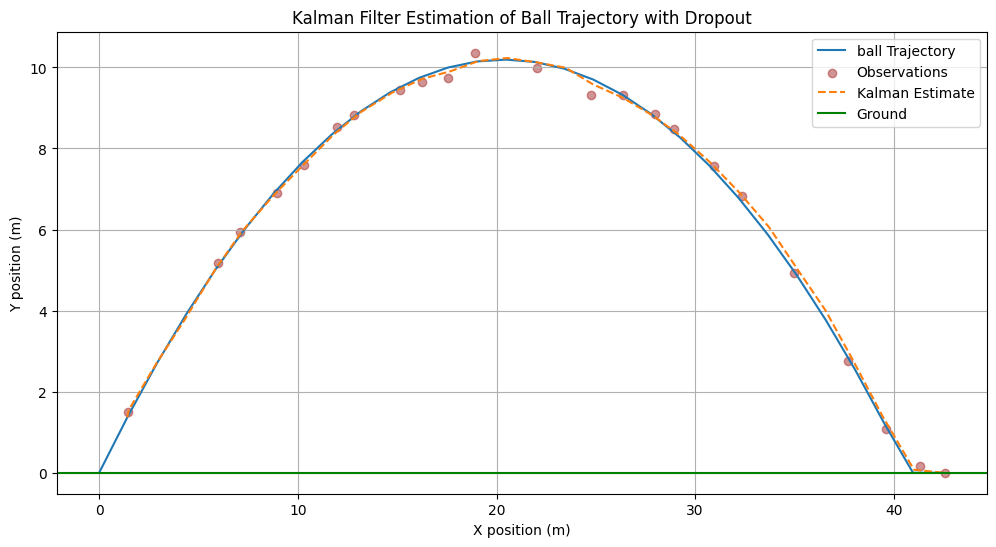

In [23]:
# Plotting the graph with observed positions and particle estimates
plt.figure(figsize=(12, 6))
plt.plot(x_true_pos, y_true_pos, label='ball Trajectory')
plt.scatter(obs_x, obs_y, color='brown', label='Observations', alpha=0.5)
plt.plot(estimated_states[:, 0], estimated_states[:, 1], label='Kalman Estimate', linestyle='--')
plt.xlabel('X position (m)')
plt.ylabel('Y position (m)')
plt.title('Kalman Filter Estimation of Ball Trajectory with Dropout')
plt.axhline(0, color='green', linestyle='-', label='Ground')
plt.legend()
plt.grid(True)
plt.show()


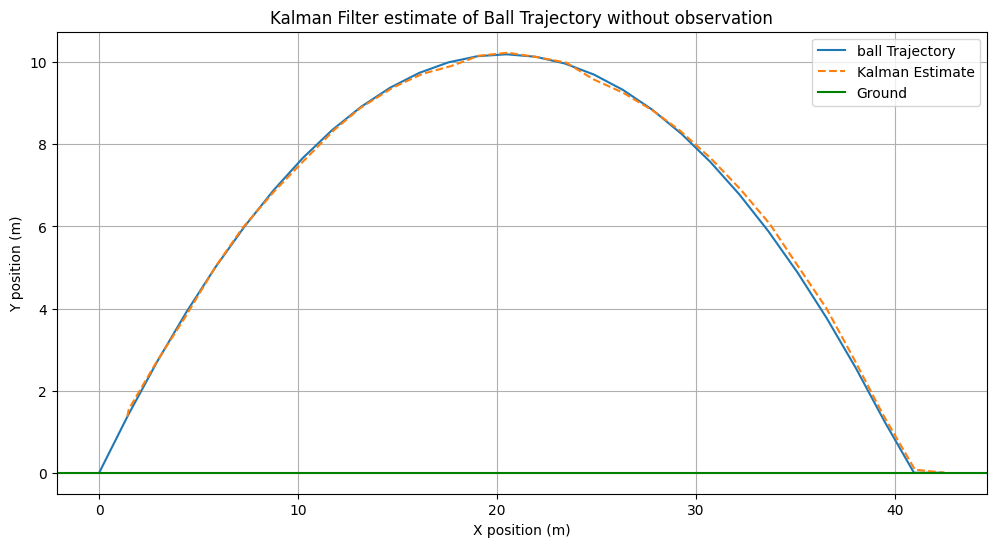

In [24]:
# Plotting graph without obsevation for better visiblity
plt.figure(figsize=(12, 6))
plt.plot(x_true_pos, y_true_pos, label='ball Trajectory')
plt.plot(estimated_states[:, 0], estimated_states[:, 1], label='Kalman Estimate', linestyle='--')
plt.xlabel('X position (m)')
plt.ylabel('Y position (m)')
plt.title('Kalman Filter estimate of Ball Trajectory without observation')
plt.axhline(0, color='green', linestyle='-', label='Ground')
plt.legend()
plt.grid(True)
plt.show()
